# Import Library

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from tqdm import tqdm
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from keras.layers import BatchNormalization
from keras.layers import Input, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import applications

# Data Visualization

In [2]:
train = list(os.walk('train'))

In [3]:
label_names = train[0][1]
dict_labels = dict(zip(label_names, list(range(len(label_names)))))
print(dict_labels)

{'asiatic rice borer': 0, 'brown plant hopper': 1, 'paddy stem maggot': 2, 'rice gall midge': 3, 'rice leaf caterpillar': 4, 'rice leaf roller': 5, 'rice leafhopper': 6, 'rice water weevil': 7, 'small brown plant hopper': 8, 'yellow rice borer': 9}


In [4]:
def dataset(path):
    images = []
    labels = []
    for folder in tqdm(os.listdir(path)):
        value_of_label = dict_labels[folder]

        for file in (os.listdir(os.path.join(path, folder))):
            path_of_file = os.path.join(os.path.join(path, folder), file)

            image = cv2.imread(path_of_file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (150, 150))
            images.append(image)
            labels.append(value_of_label)

    images = np.array(images, dtype = 'float32')/255.0
    labels = np.array(labels)

    return images, labels

images, labels = dataset('train')
images, labels = shuffle(images, labels)

100%|██████████| 10/10 [00:02<00:00,  4.36it/s]


In [5]:
images.shape

(3156, 150, 150, 3)

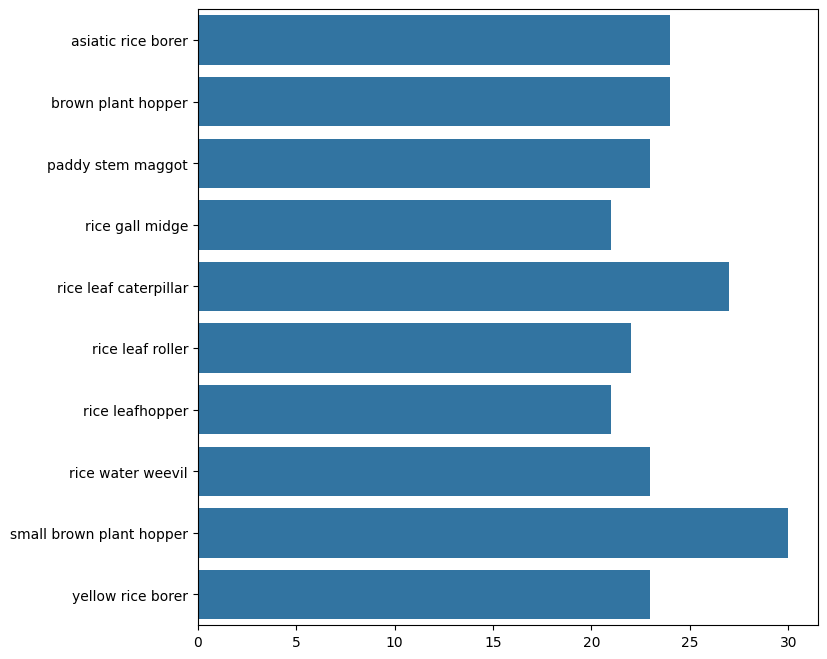

In [6]:
species = list(dict_labels.keys()) 
no_of_pest = []
for _ in range(1, len(species) + 1):
    no_of_pest.append(len(train[_][0]))
plt.figure(figsize = (8, 8))
sns.barplot(y=species, x=no_of_pest);

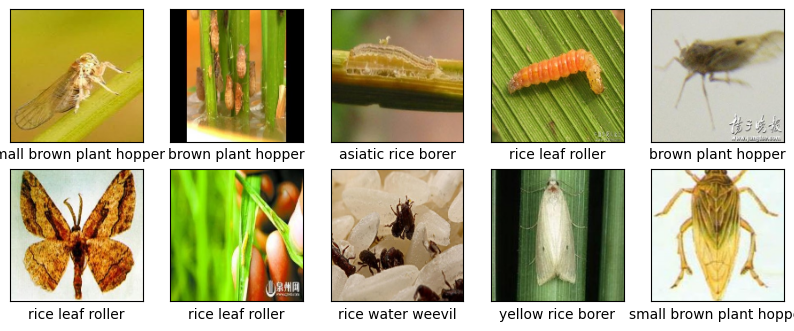

In [7]:
plt.figure(figsize = (10,10))
for _ in range(10):
    plt.subplot(5, 5, _+1)
    plt.yticks([])
    plt.xticks([])
    plt.grid(False)
    data = images[_]
    plt.xlabel(label_names[labels[_]])
    plt.imshow(data);

# Load Images

In [8]:
image_size = (224, 224)
batch_size = 64
train_datagen = ImageDataGenerator(rescale = 1./255,
                            shear_range = 0.4,
                            zoom_range = 0.4,
                            horizontal_flip = True,
                            vertical_flip = True,
                            validation_split = 0.2)

In [9]:
train_ds = train_datagen.flow_from_directory('train',
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'training',
                                      color_mode="rgb",)

val_ds = train_datagen.flow_from_directory('train',
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'validation',
                                      color_mode="rgb")

Found 2530 images belonging to 10 classes.
Found 626 images belonging to 10 classes.


In [10]:
train_ds.class_indices

{'asiatic rice borer': 0,
 'brown plant hopper': 1,
 'paddy stem maggot': 2,
 'rice gall midge': 3,
 'rice leaf caterpillar': 4,
 'rice leaf roller': 5,
 'rice leafhopper': 6,
 'rice water weevil': 7,
 'small brown plant hopper': 8,
 'yellow rice borer': 9}

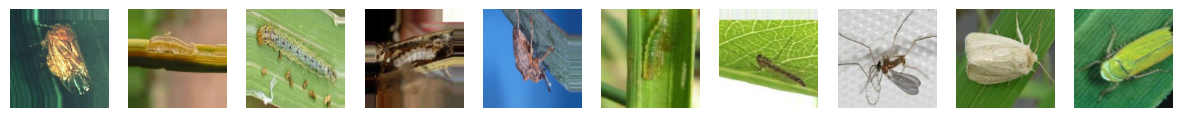

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(15,15))

for i in range(10):
    image = next(train_ds)[0][0]
    image = np.squeeze(image)
    ax[i].imshow(image)
    ax[i].axis(False)

# Transfer learning

### Xception

In [12]:
xcep_base = applications.Xception(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
xcep_base.trainable = False

In [13]:
inputs = Input(shape=(224, 224, 3))

x = xcep_base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation = 'softmax')(x)
xcep_model = Model(inputs, outputs)

In [14]:
xcep_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss= keras.losses.CategoricalCrossentropy(from_logits = False),
    metrics= [keras.metrics.CategoricalAccuracy()],
)

In [15]:
epochs = 25
xcep_model.fit(train_ds, epochs=epochs, validation_data=val_ds)

c:\Users\nurri\.virtualenvs\Transfer_Learning-7EYz9JuJ\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - categorical_accuracy: 0.3770 - loss: 1.8512 - val_categorical_accuracy: 0.6214 - val_loss: 1.2193
Epoch 2/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - categorical_accuracy: 0.6285 - loss: 1.1178 - val_categorical_accuracy: 0.6470 - val_loss: 1.0749
Epoch 3/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - categorical_accuracy: 0.6616 - loss: 1.0378 - val_categorical_accuracy: 0.6581 - val_loss: 1.0888
Epoch 4/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - categorical_accuracy: 0.6861 - loss: 0.9369 - val_categorical_accuracy: 0.6789 - val_loss: 1.0118
Epoch 5/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - categorical_accuracy: 0.7169 - loss: 0.8394 - val_categorical_accuracy: 0.7188 - val_loss: 0.9410
Epoch 6/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - categorical_accuracy: 0.7448 - loss: 0.7933 - val_categorical_accuracy: 0.6821 - val_loss: 1.0150
Epoch 7/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - categorical_accuracy: 0.7414 - loss: 0.77

### ResNet152V2

In [16]:
res_base = applications.ResNet152V2(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
res_base.trainable = False

In [17]:
inputs = Input(shape=(224, 224, 3))

x = res_base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation = 'softmax')(x)
res_model = Model(inputs, outputs)

In [18]:
res_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss= keras.losses.CategoricalCrossentropy(from_logits = False),
    metrics= [keras.metrics.CategoricalAccuracy()],
)

In [19]:
epochs = 25
res_model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 256s 6s/step - categorical_accuracy: 0.3777 - loss: 2.4715 - val_categorical_accuracy: 0.6454 - val_loss: 1.1288
Epoch 2/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 242s 6s/step - categorical_accuracy: 0.6724 - loss: 0.9857 - val_categorical_accuracy: 0.6837 - val_loss: 1.0395
Epoch 3/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 240s 6s/step - categorical_accuracy: 0.7111 - loss: 0.9004 - val_categorical_accuracy: 0.6869 - val_loss: 0.9794
Epoch 4/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 242s 6s/step - categorical_accuracy: 0.7340 - loss: 0.7867 - val_categorical_accuracy: 0.7188 - val_loss: 0.9384
Epoch 5/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 237s 6s/step - categorical_accuracy: 0.7728 - loss: 0.7045 - val_categorical_accuracy: 0.7364 - val_loss: 0.8904
Epoch 6/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 236s 6s/step - categorical_accuracy: 0.7783 - loss: 0.6836 - val_categorical_accuracy: 0.7077 - val_loss: 0.9310
Epoch 7/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 236s 6s/step - categorical_accuracy: 0.7981 - loss: 0.62

### InceptionV3

In [20]:
incep_base = applications.InceptionV3(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
incep_base.trainable = False

In [21]:
inputs = Input(shape=(224, 224, 3))

x = incep_base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation = 'softmax')(x)
incep_model = Model(inputs, outputs)

In [22]:
incep_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss= keras.losses.CategoricalCrossentropy(from_logits = False),
    metrics= [keras.metrics.CategoricalAccuracy()],
)

In [23]:
epochs = 25
incep_model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - categorical_accuracy: 0.2934 - loss: 3.0730 - val_categorical_accuracy: 0.5575 - val_loss: 1.4102
Epoch 2/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - categorical_accuracy: 0.5634 - loss: 1.3210 - val_categorical_accuracy: 0.5863 - val_loss: 1.2301
Epoch 3/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - categorical_accuracy: 0.6105 - loss: 1.1850 - val_categorical_accuracy: 0.6038 - val_loss: 1.1780
Epoch 4/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - categorical_accuracy: 0.6469 - loss: 1.0596 - val_categorical_accuracy: 0.6310 - val_loss: 1.1265
Epoch 5/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - categorical_accuracy: 0.6337 - loss: 1.0821 - val_categorical_accuracy: 0.6166 - val_loss: 1.1438
Epoch 6/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - categorical_accuracy: 0.6847 - loss: 0.9466 - val_categorical_accuracy: 0.6406 - val_loss: 1.0739
Epoch 7/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - categorical_accuracy: 0.6808 - loss: 0.9766 - va

### MobileNetV2

In [24]:
mobile_base = applications.MobileNetV2(weights='imagenet', include_top = False, input_shape=(224, 224, 3))
mobile_base.trainable = False

In [25]:
inputs = Input(shape=(224, 224, 3))

x = mobile_base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)

mobile_model = Model(inputs, outputs)

In [26]:
mobile_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss= keras.losses.CategoricalCrossentropy(from_logits = False),
    metrics= [keras.metrics.CategoricalAccuracy()],
)

In [27]:
epochs = 25
mobile_model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - categorical_accuracy: 0.3369 - loss: 2.2890 - val_categorical_accuracy: 0.6182 - val_loss: 1.1889
Epoch 2/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - categorical_accuracy: 0.6409 - loss: 1.1462 - val_categorical_accuracy: 0.6550 - val_loss: 1.1226
Epoch 3/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - categorical_accuracy: 0.6712 - loss: 0.9958 - val_categorical_accuracy: 0.6837 - val_loss: 1.0174
Epoch 4/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - categorical_accuracy: 0.7079 - loss: 0.8848 - val_categorical_accuracy: 0.6805 - val_loss: 0.9758
Epoch 5/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - categorical_accuracy: 0.7253 - loss: 0.8213 - val_categorical_accuracy: 0.6677 - val_loss: 0.9795
Epoch 6/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - categorical_accuracy: 0.7314 - loss: 0.8074 - val_categorical_accuracy: 0.6901 - val_loss: 0.9805
Epoch 7/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - categorical_accuracy: 0.7625 - loss: 0.7000 - va